In [1]:
import pandas as pd
import scipy.io as io
import numpy as np
import scanpy as scp
import seaborn as sns
import matplotlib.pyplot as plt

from parameters import *

import sys
sys.path.append('../../')
import single_cell_tools.tools as scttools
import single_cell_tools.plot as sctplot

In [2]:
d = pd.read_csv("GSE143637_HTSeq_counts.txt",sep="\t")
X = d.values.transpose()
obs = pd.DataFrame()
obs.loc[:,"Cell"] = [i.split("_")[0] for i in d.columns.values]
obs.loc[:,"Sorted"] = [i.split("_")[3] for i in d.columns.values]
obs.loc[:,"Stage"] = [i.split("_")[2] for i in d.columns.values]
var = pd.read_csv("genes.txt",sep="\t",header=None)
var.columns = ["ENS","gene_name"]
var = var.astype(str)

In [3]:
adata = scp.AnnData(X)
adata.obs = obs
adata.var = var
adata.layers["Raw"] = X.copy()

# Quality control

In [4]:
mtgenes = ["mt-" in i for i in adata.var.loc[:,"gene_name"].values]
scttools.qc_metrics(adata,mtgenes)

# Plot S3

In [5]:
adata.X = adata.layers["Raw"].copy()
scp.pp.normalize_total(adata,target_sum=np.mean(adata.obs["#counts"].values))
scp.pp.log1p(adata)
scp.pp.highly_variable_genes(adata)
scp.pp.pca(adata,n_comps=20,use_highly_variable=True)
scp.pp.neighbors(adata,metric="euclidean",knn=20)
scp.tl.umap(adata)

2022-08-25 09:41:32.543655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 09:41:32.543670: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


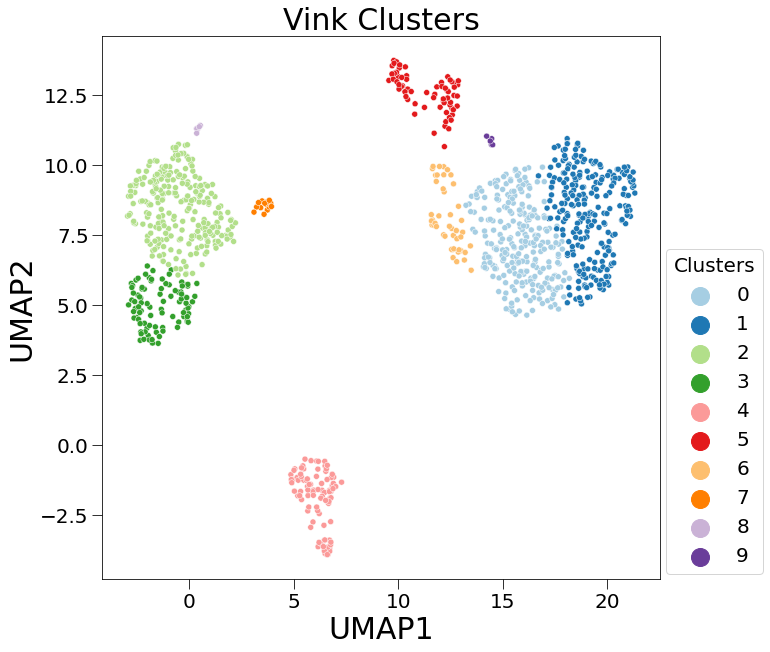

In [6]:
fig,ax = plt.subplots(figsize=[10,10])

scp.tl.leiden(adata,resolution = .5)
X = adata.obsm["X_umap"]
#hue = [i+"_"+j for i,j in adata.obs[["Stage","Sorted"]].values]
hue = adata.obs["leiden"]
sns.scatterplot(x=X[:,0],y=X[:,1],hue=hue,palette="Paired")
sctplot.plot_base(ax,labels=["UMAP1","UMAP2"],title="Vink Clusters",legend_title="Clusters",legend_size=20,legend_markerscale=3,legend_pos=(1.01,0.01))

fig.savefig("Plots/VinkS3_umaps.pdf",bbox_inches="tight",transparent=True)
plt.show()

In [7]:
adata.write("Vink_S3.h5ad")

... storing 'Sorted' as categorical
... storing 'Stage' as categorical
... storing 'gene_name' as categorical


## DE

In [8]:
scp.tl.rank_genes_groups(adata,groupby="leiden",method="wilcoxon",use_raw=False)
scttools.rank_genes_to_excel(adata,"gene_name","Tables/VinkS3_annotation.xlsx",2000)

/home/jovyan/Data_other_studies/Vink/../../single_cell_tools/tools/annotation.py:29: RuntimeWarning: divide by zero encountered in true_divide
  l.loc[:,"logfoldchanges"] = [np.log(adata[pop1,adata.var.loc[:,gene_name]==j].layers[layer].mean()/adata[pop2,adata.var.loc[:,gene_name]==j].layers[layer].mean()) for j in l.loc[:,"names"]]


## Enrichr

In [9]:
ENRICHR_LIBRARIES = ["Descartes_Cell_Types_and_Tissue_2021","PanglaoDB_Augmented_2021"]

In [10]:
for library in ENRICHR_LIBRARIES:
    scttools.enrichr_to_excel(adata,library,"Tables/VinkS3_Enrich_"+library+".xlsx")

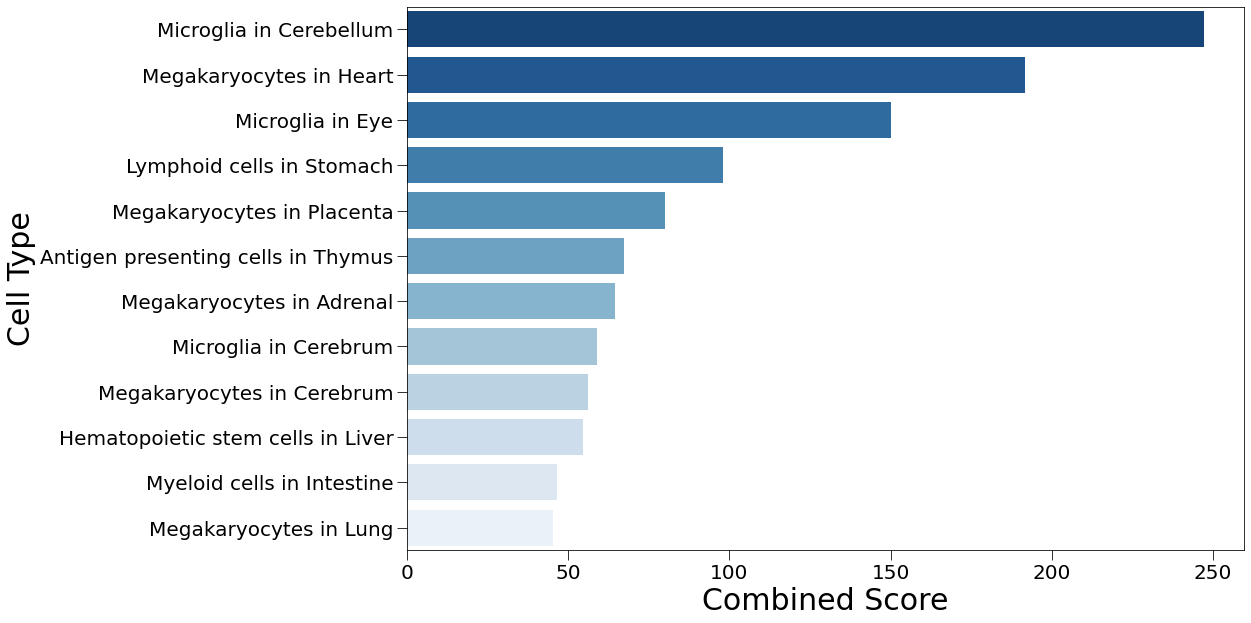

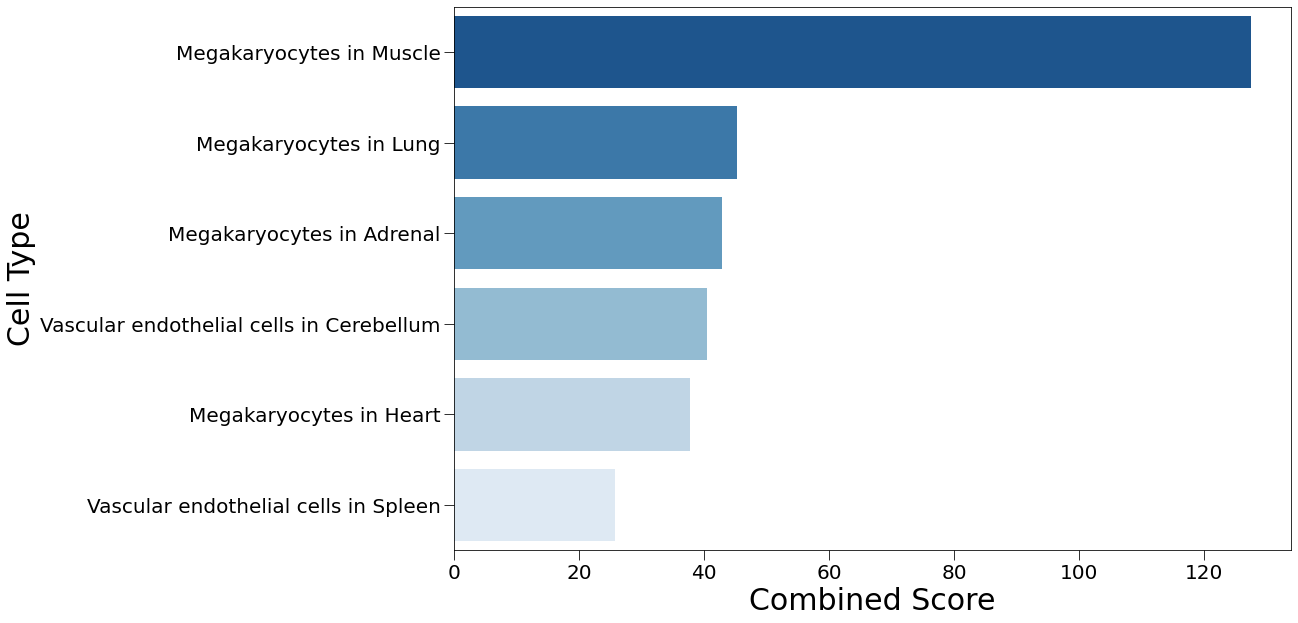

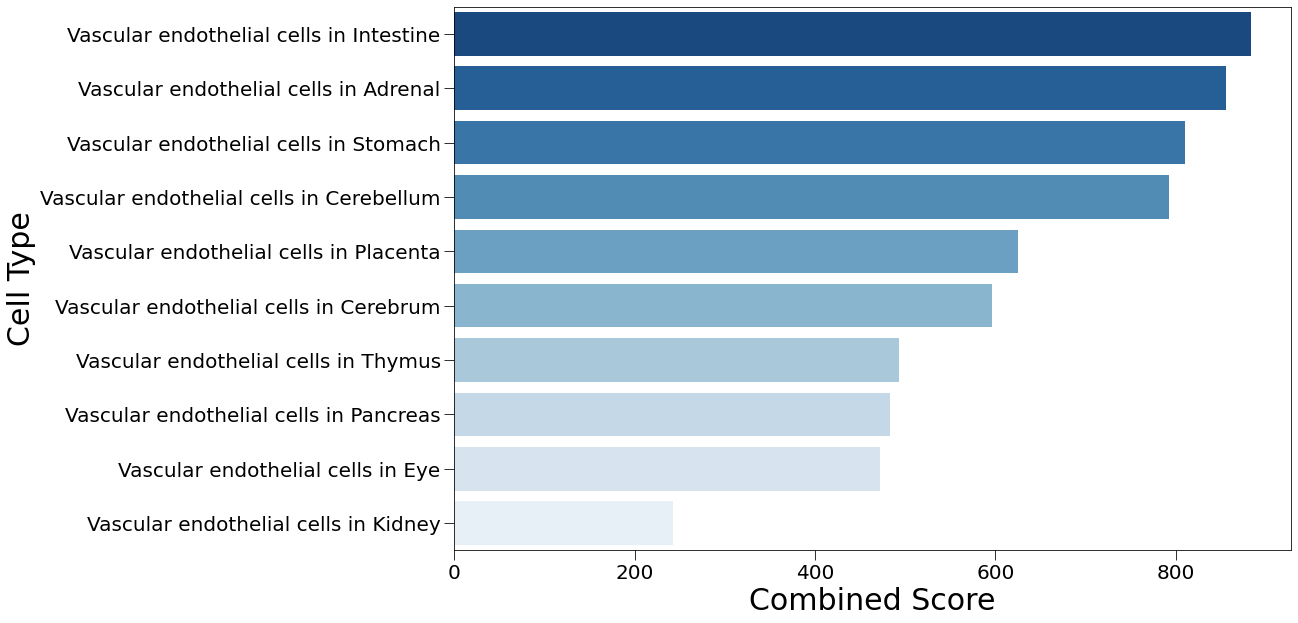

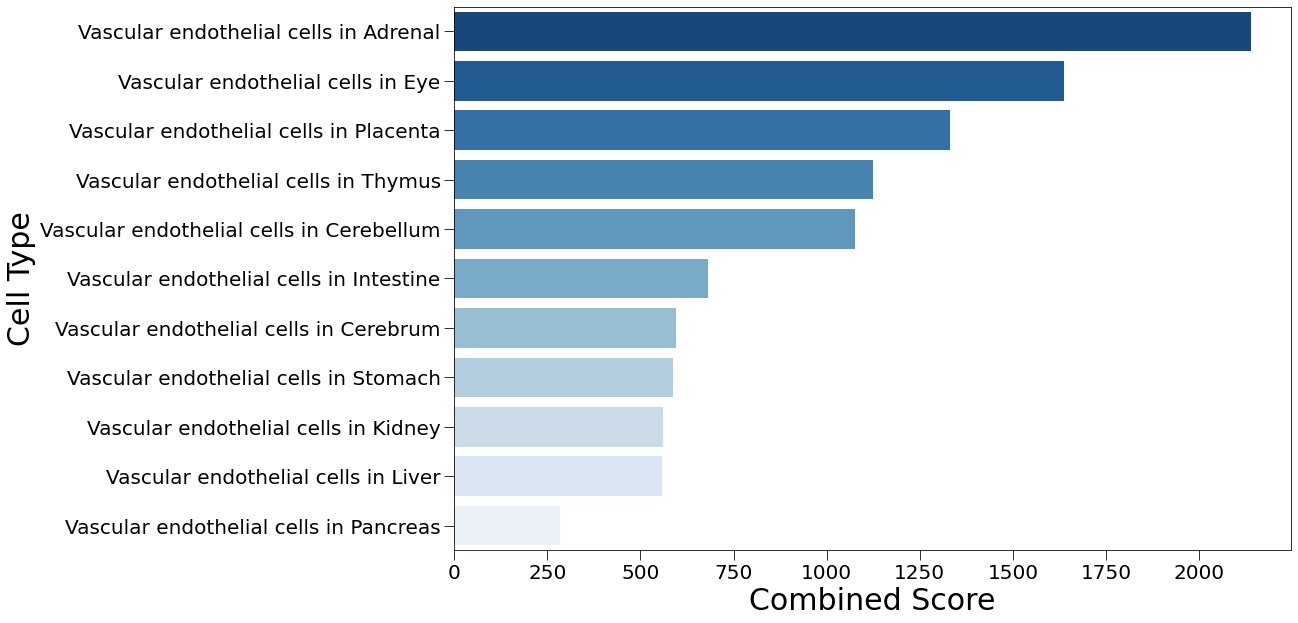

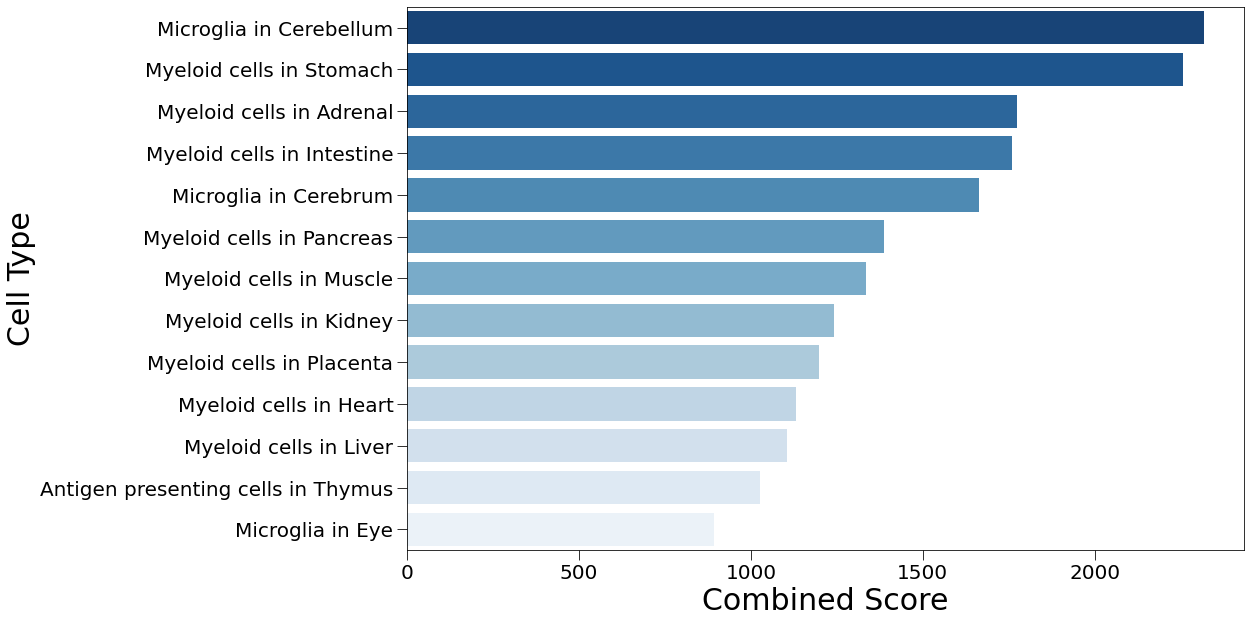

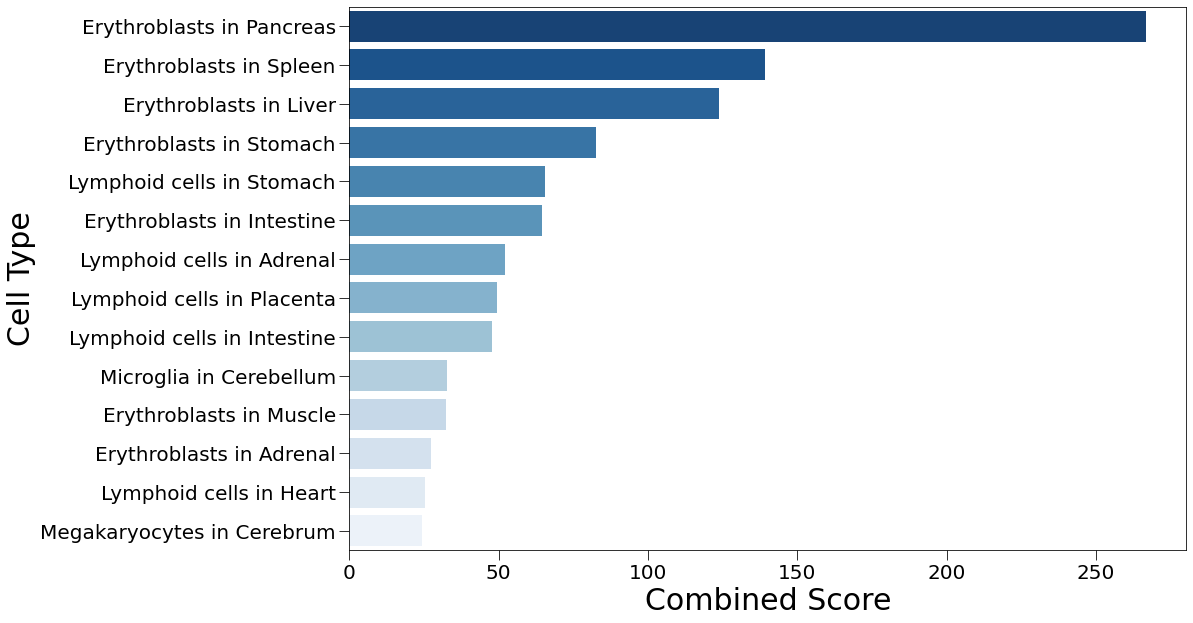

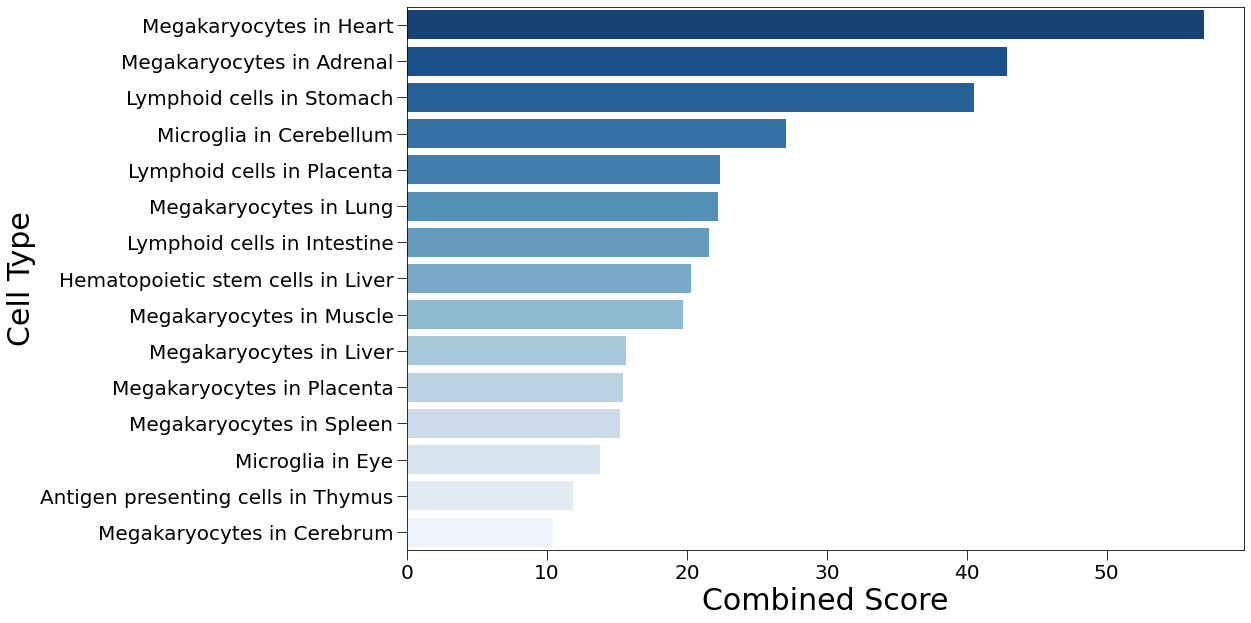

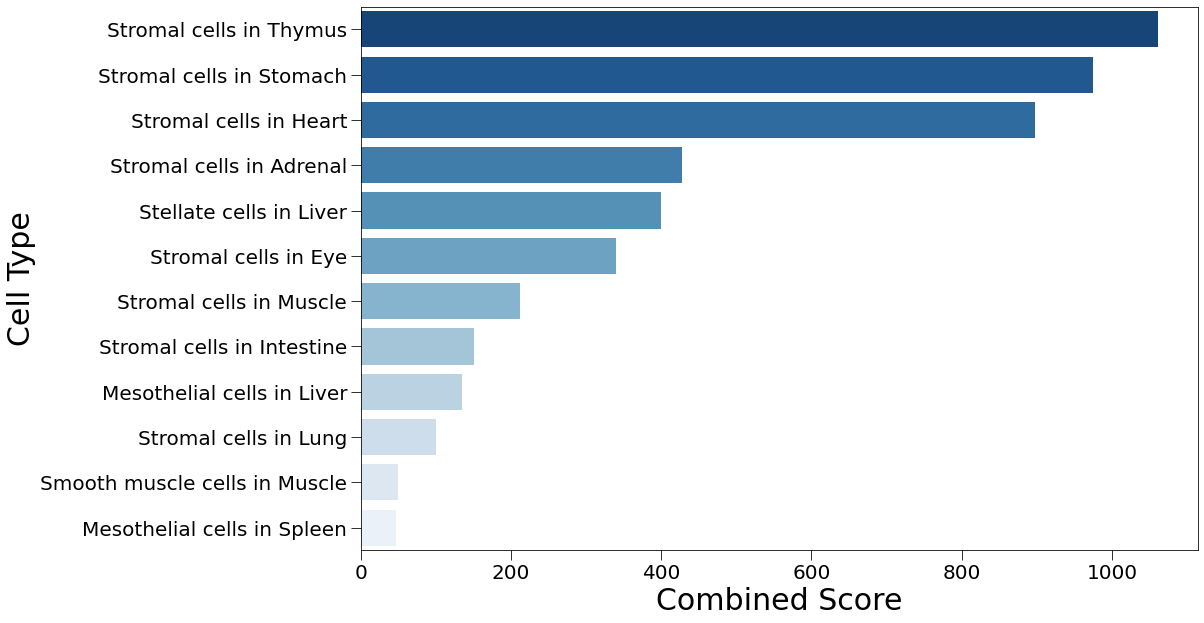

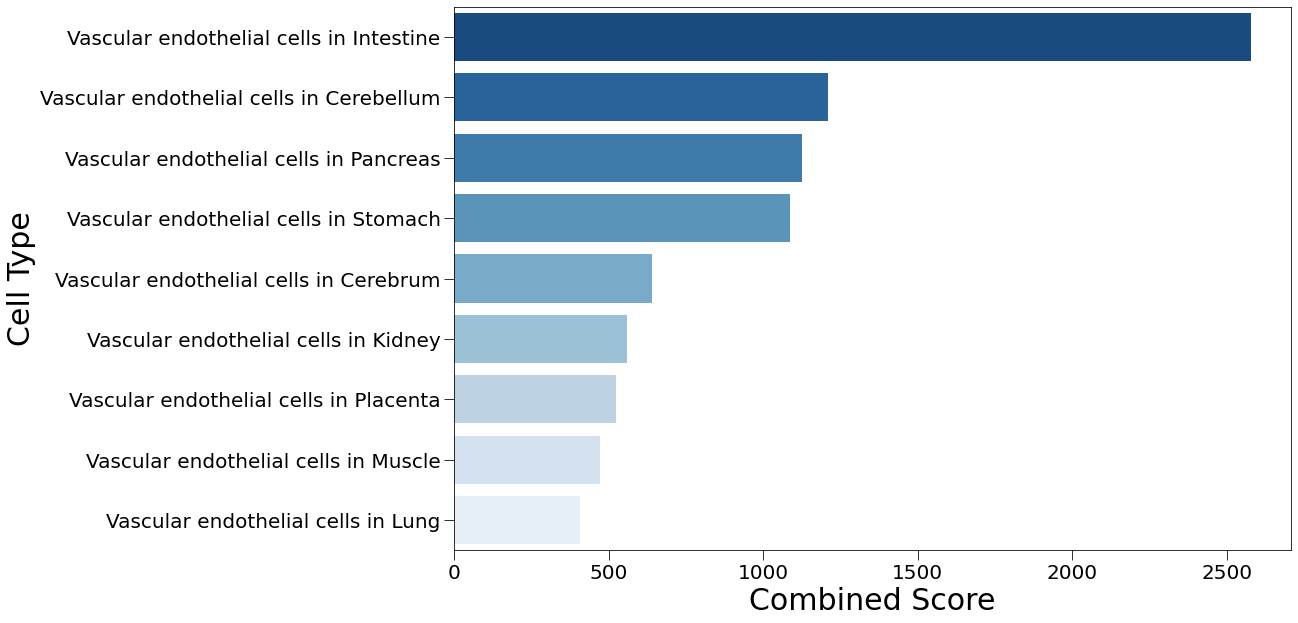

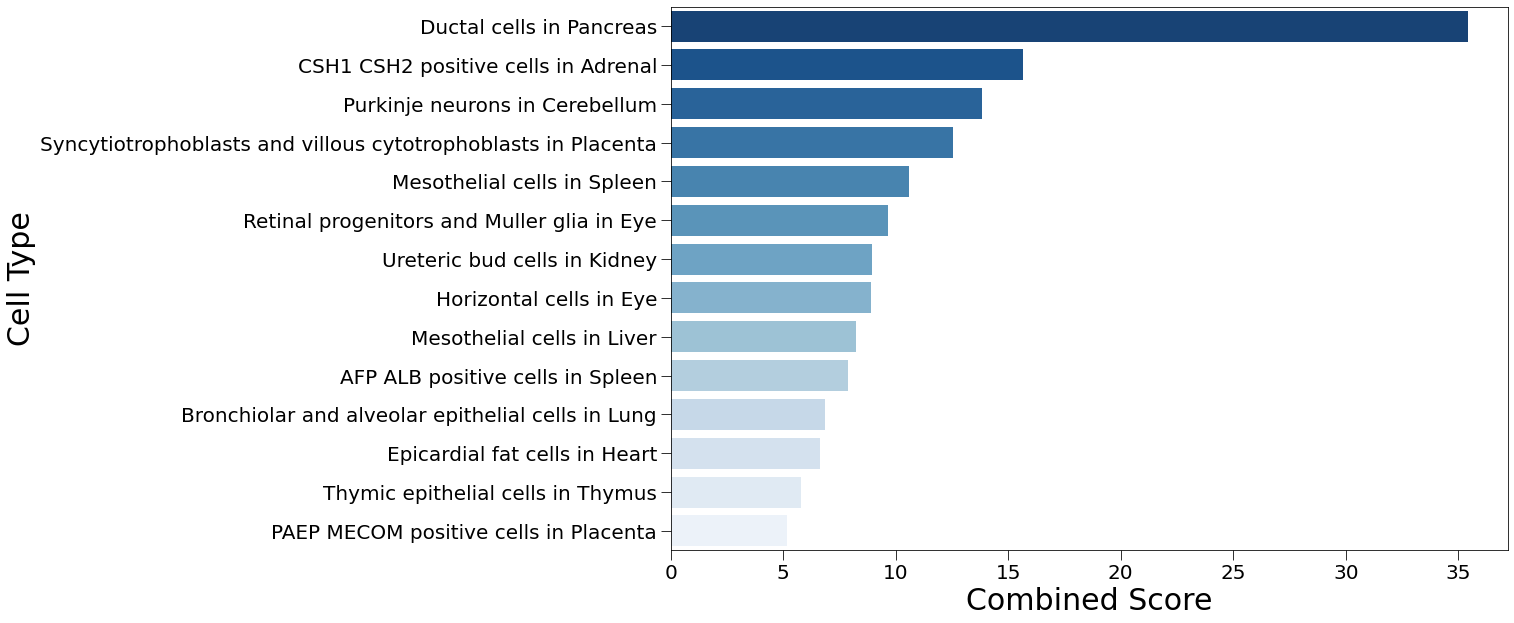

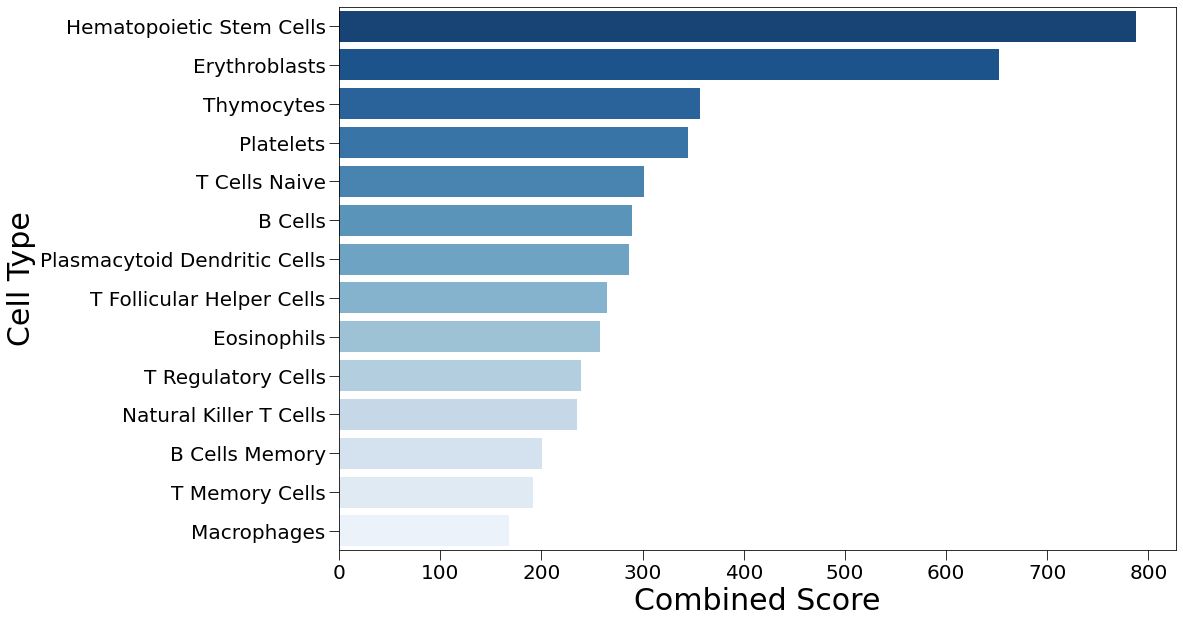

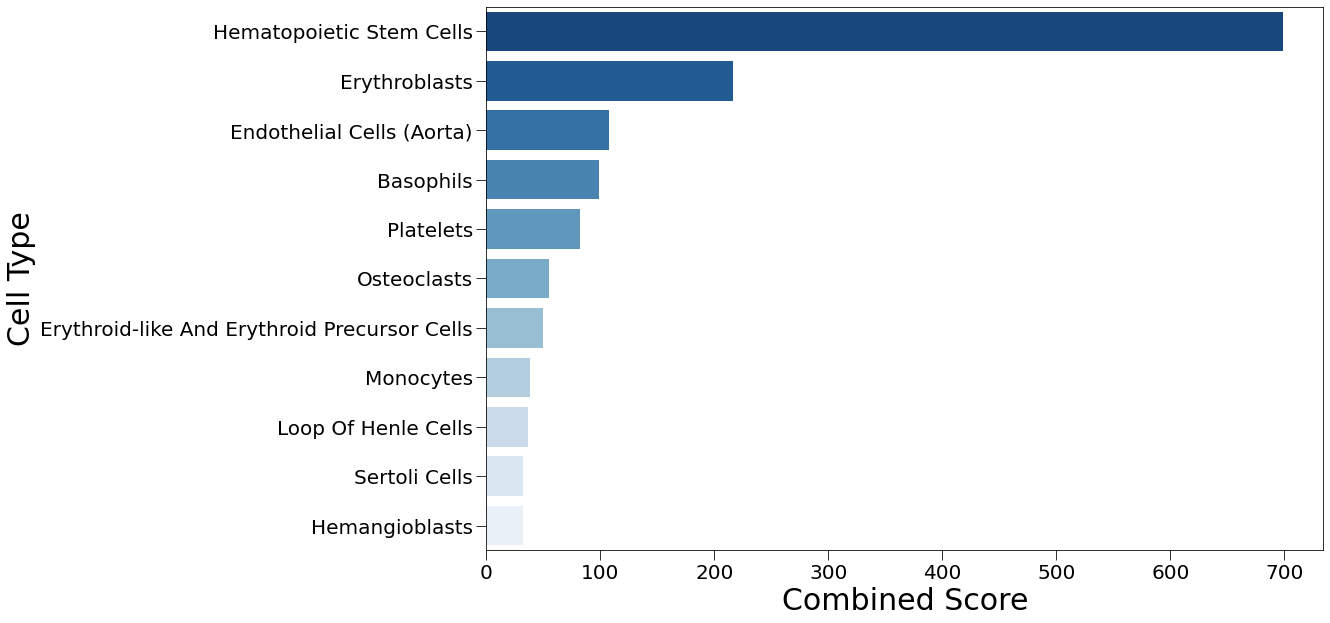

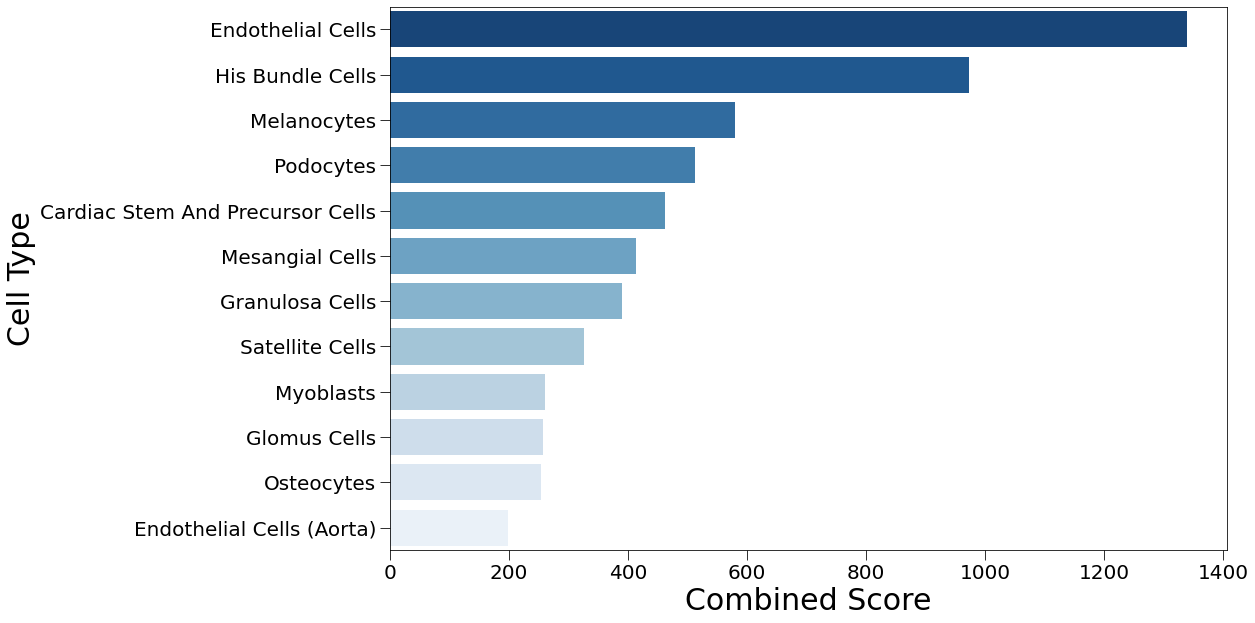

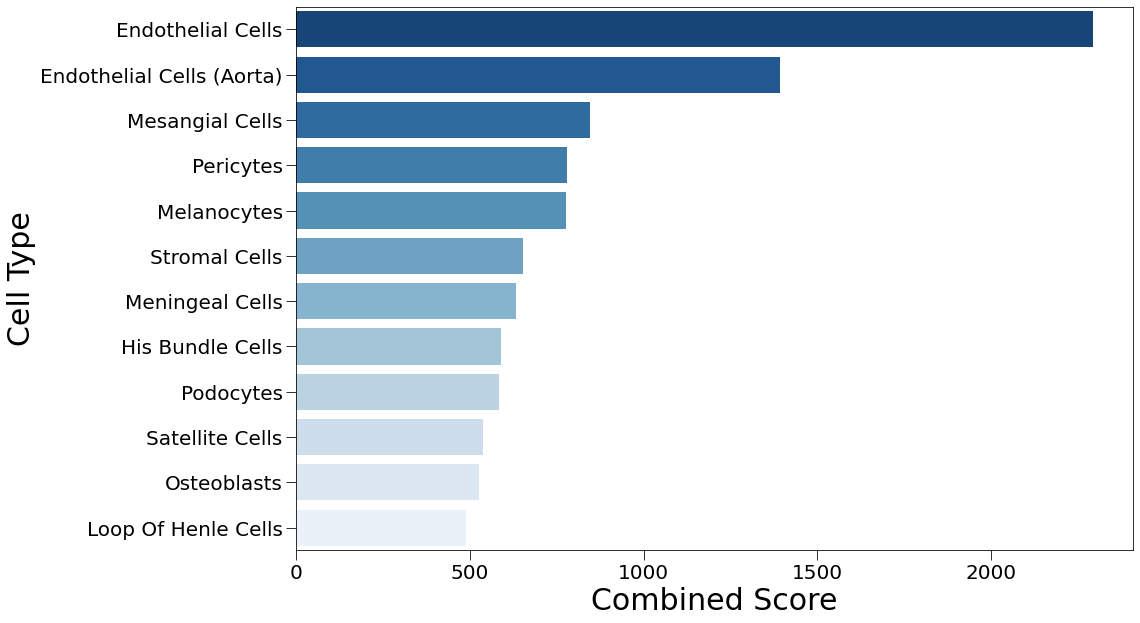

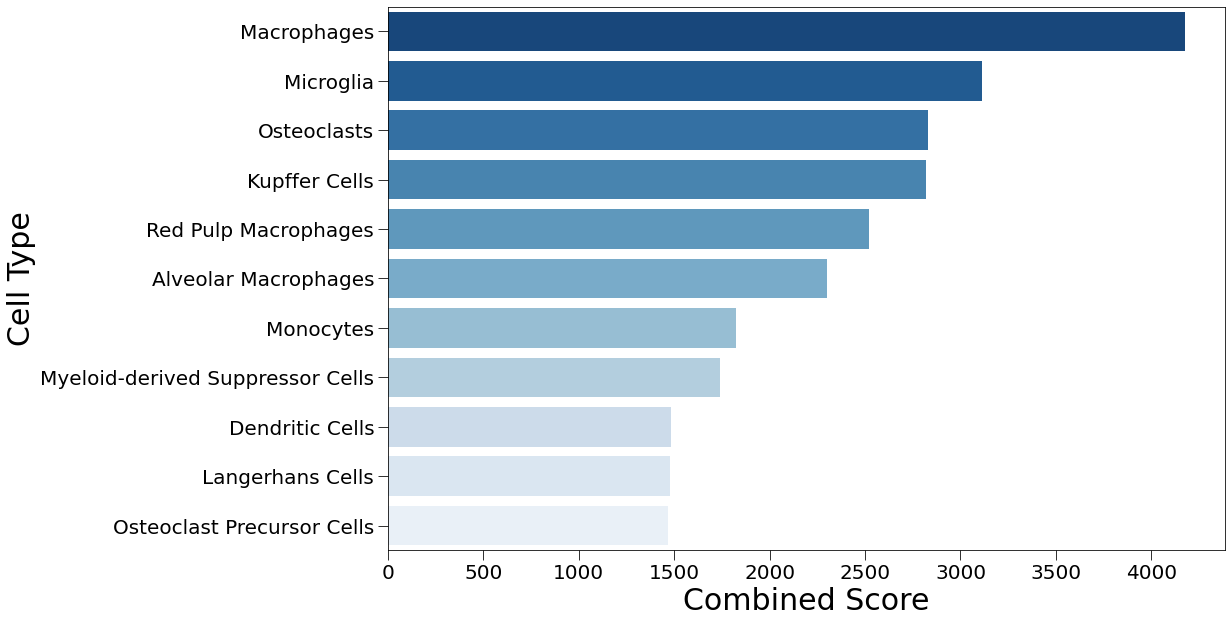

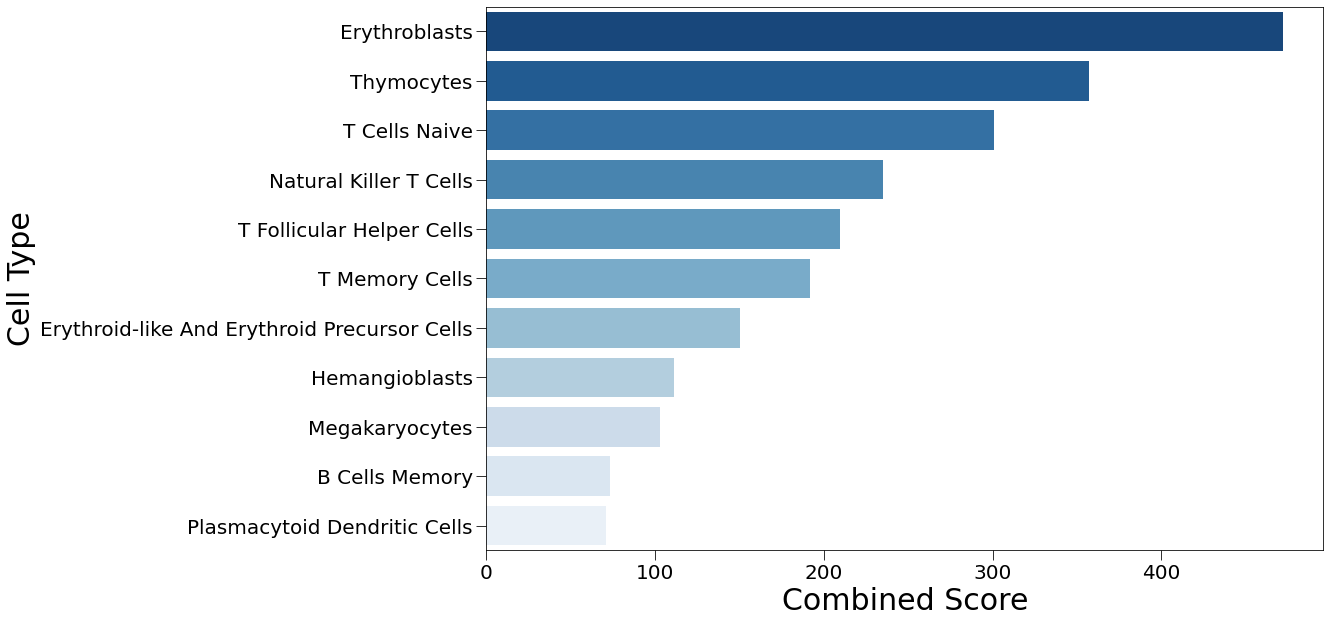

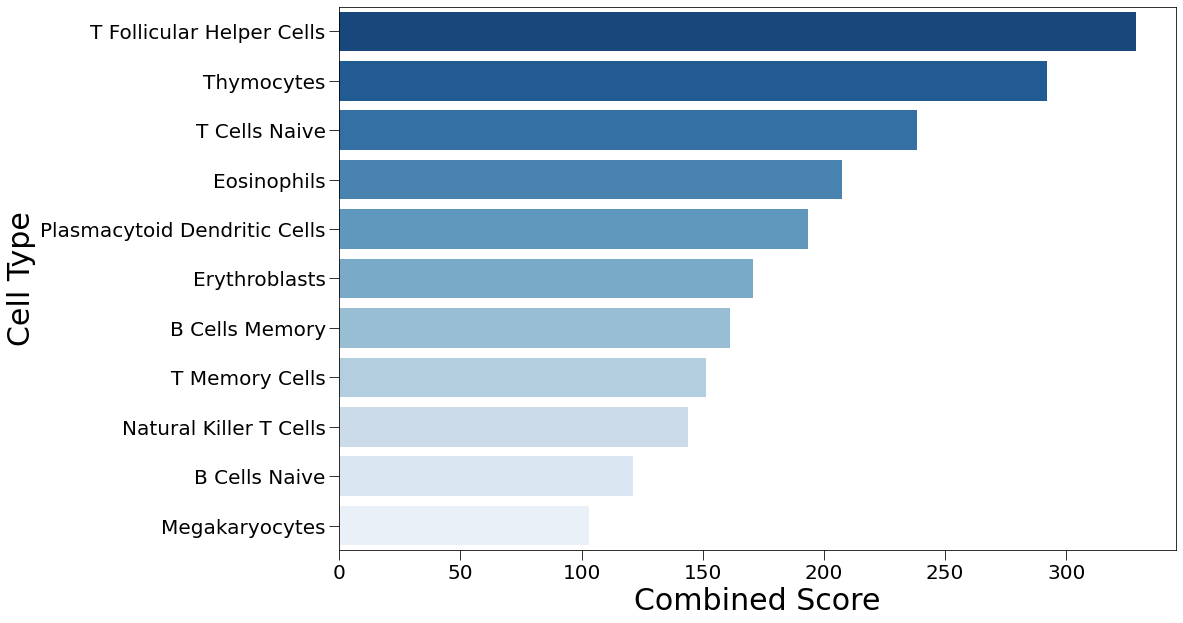

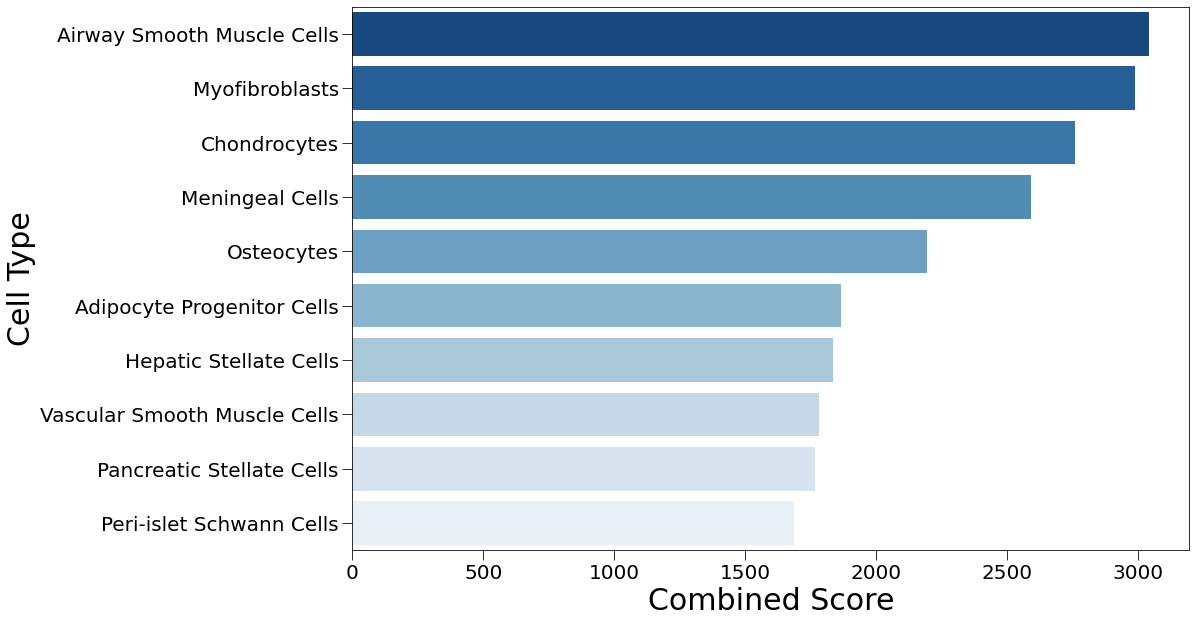

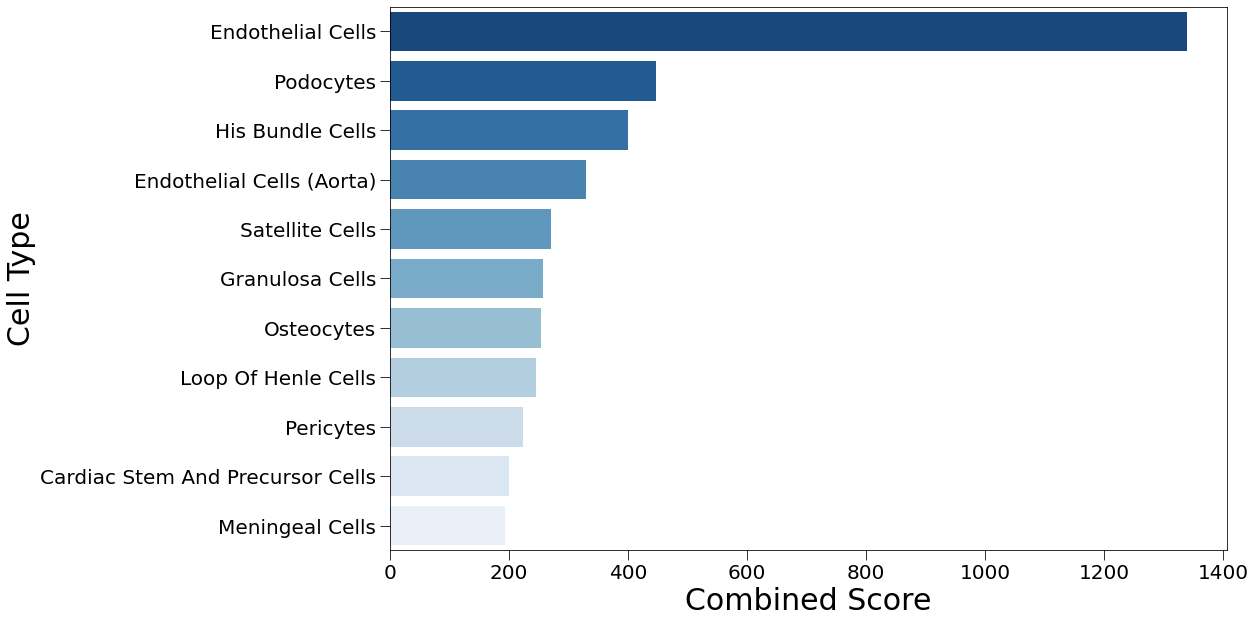

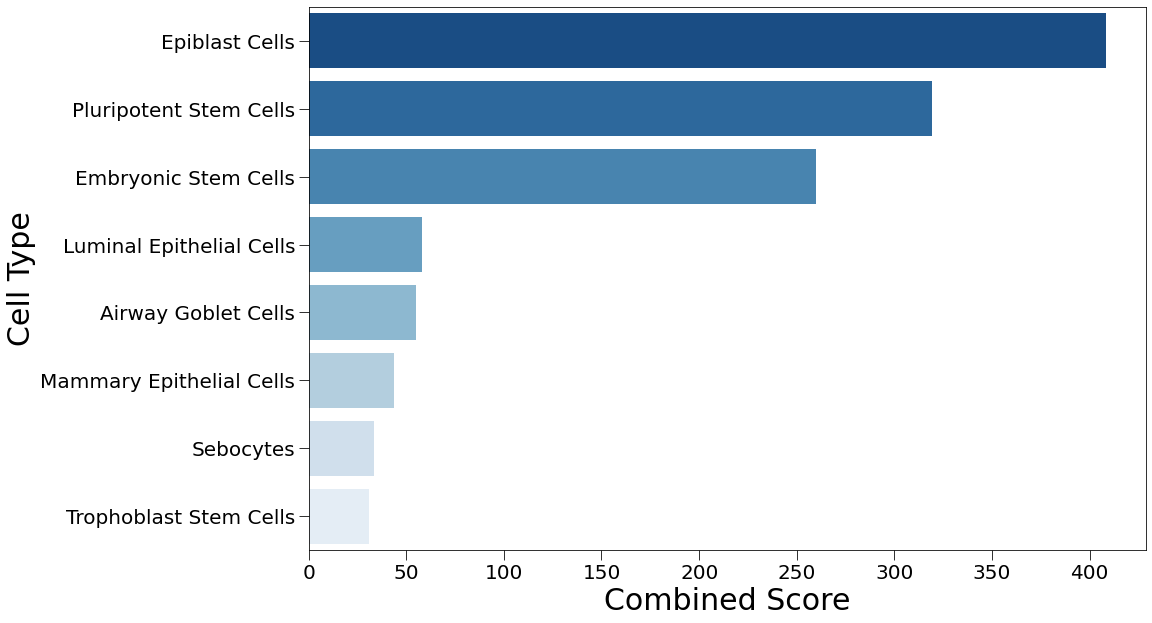

In [11]:
for library in ENRICHR_LIBRARIES:
    for sheet in pd.ExcelFile("Tables/VinkS3_Enrich_"+library+".xlsx").sheet_names:
        data = pd.read_excel("Tables/VinkS3_Enrich_"+library+".xlsx",sheet_name=sheet)
        data.sort_values("Combined Score",ascending=False,inplace=True)
        
        fig,ax=plt.subplots(figsize=[15,10])
        sns.barplot(data = data.loc[:10,:],x="Combined Score",y="Name",palette="Blues_r",ax=ax)
        sctplot.plot_base(ax,labels=["Combined Score","Cell Type"],legend=False)
        
        fig.savefig("Plots/VinkS3_"+library+"_"+sheet+".pdf",transparent=True,bbox_inches="tight")

# Figure 2

In [12]:
adata = scp.read("Vink_S3.h5ad")
adata = adata[adata.obs["Sorted"]!="CD45+"]

/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Trying to set attribute `.obs` of view, copying.


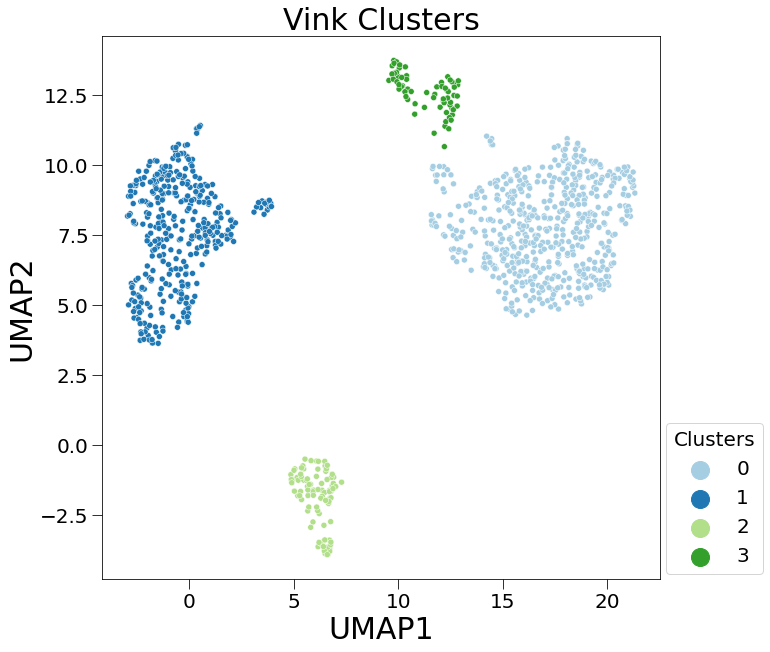

In [13]:
fig,ax = plt.subplots(figsize=[10,10])

scp.tl.leiden(adata,resolution = .1)
X = adata.obsm["X_umap"]
hue = adata.obs["leiden"]
sns.scatterplot(x=X[:,0],y=X[:,1],hue=hue,palette="Paired")
sctplot.plot_base(ax,labels=["UMAP1","UMAP2"],title="Vink Clusters",legend_title="Clusters",legend_size=20,legend_markerscale=3,legend_pos=(1.01,0.01))

fig.savefig("Plots/Vink2_umaps.pdf",bbox_inches="tight",transparent=True)
plt.show()

In [14]:
adata.write("Vink_Fig2.h5ad")

## DE

In [15]:
scp.tl.rank_genes_groups(adata,groupby="leiden",method="wilcoxon",use_raw=False)
scttools.rank_genes_to_excel(adata,"gene_name","Tables/Vink2_annotation.xlsx",2000)

/home/jovyan/Data_other_studies/Vink/../../single_cell_tools/tools/annotation.py:29: RuntimeWarning: divide by zero encountered in true_divide
  l.loc[:,"logfoldchanges"] = [np.log(adata[pop1,adata.var.loc[:,gene_name]==j].layers[layer].mean()/adata[pop2,adata.var.loc[:,gene_name]==j].layers[layer].mean()) for j in l.loc[:,"names"]]


## Enrichr

In [16]:
ENRICHR_LIBRARIES = ["Descartes_Cell_Types_and_Tissue_2021","PanglaoDB_Augmented_2021"]

In [18]:
for library in ENRICHR_LIBRARIES:
    scttools.enrichr_to_excel(adata,library,"Tables/Vink2_Enrich_"+library+".xlsx")

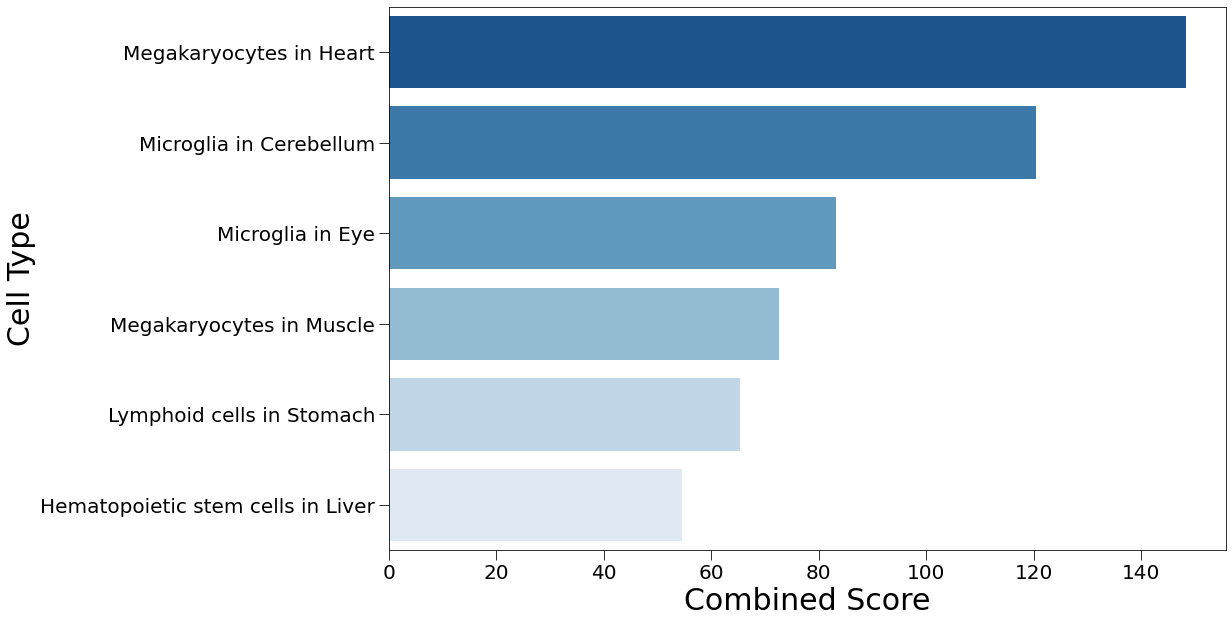

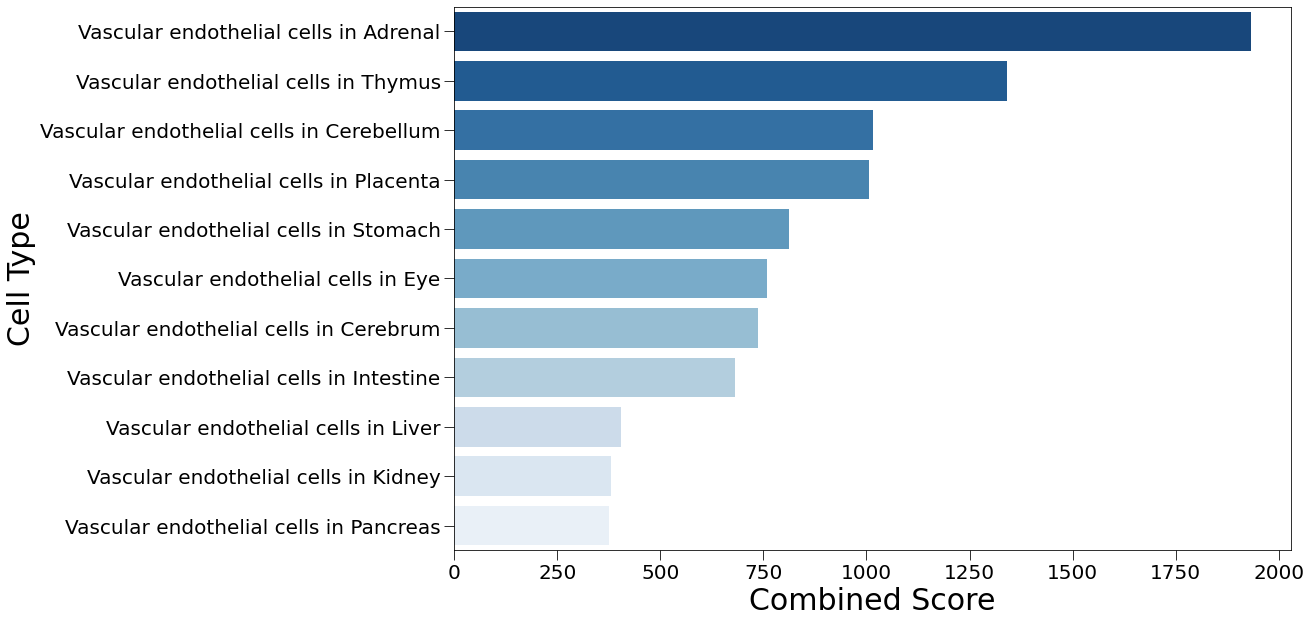

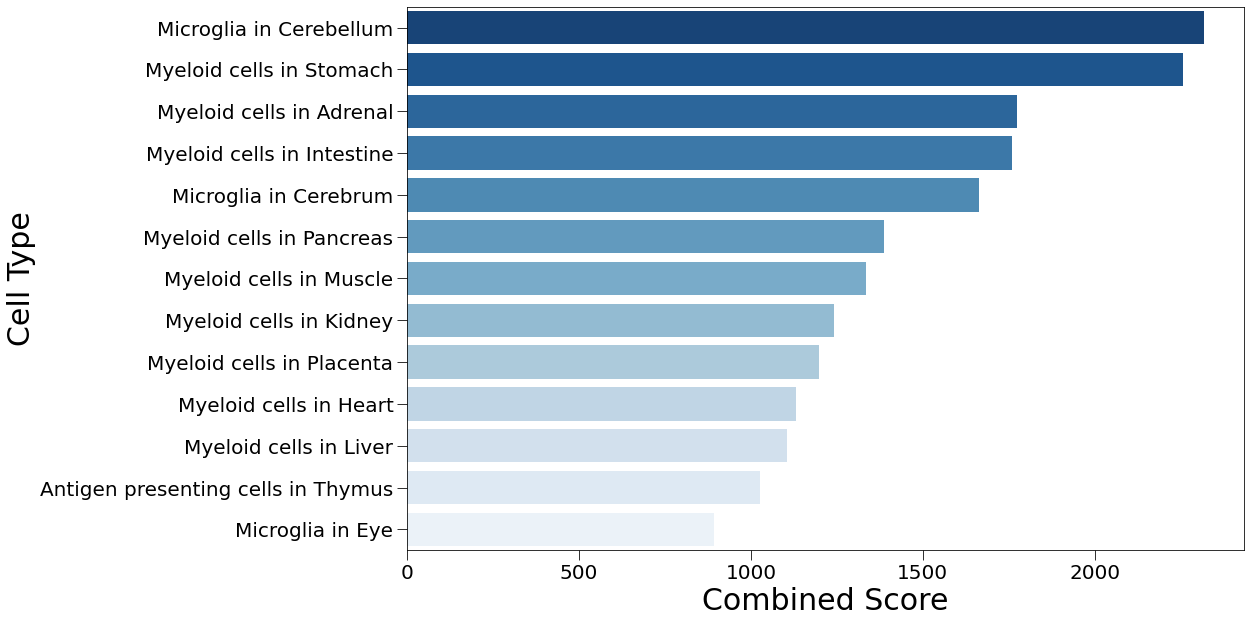

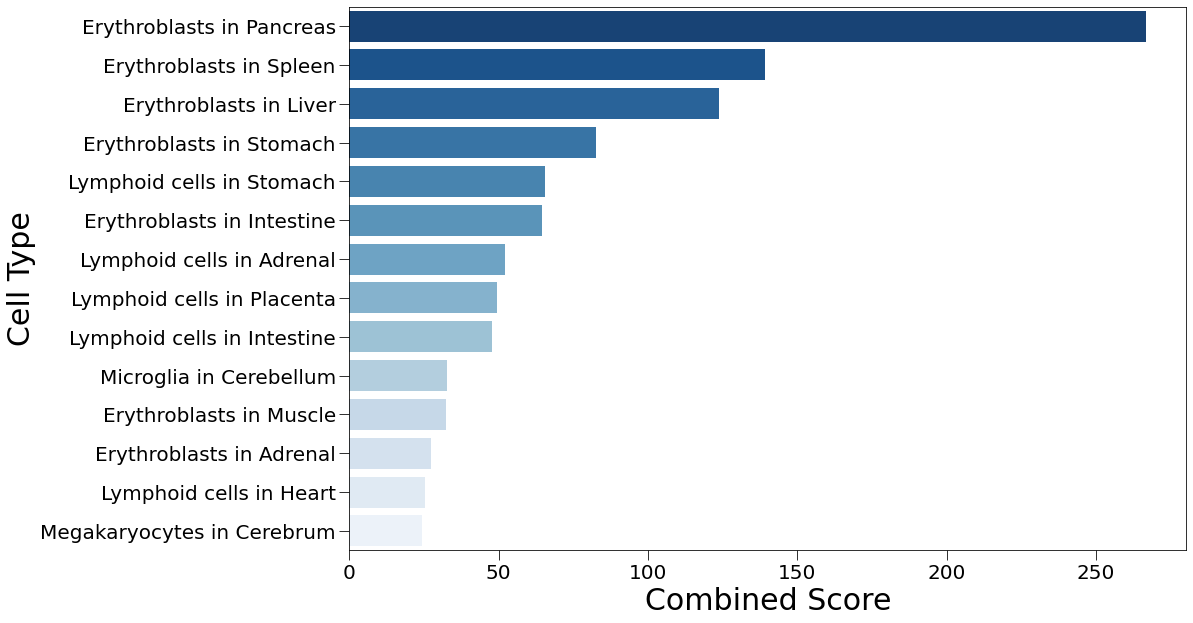

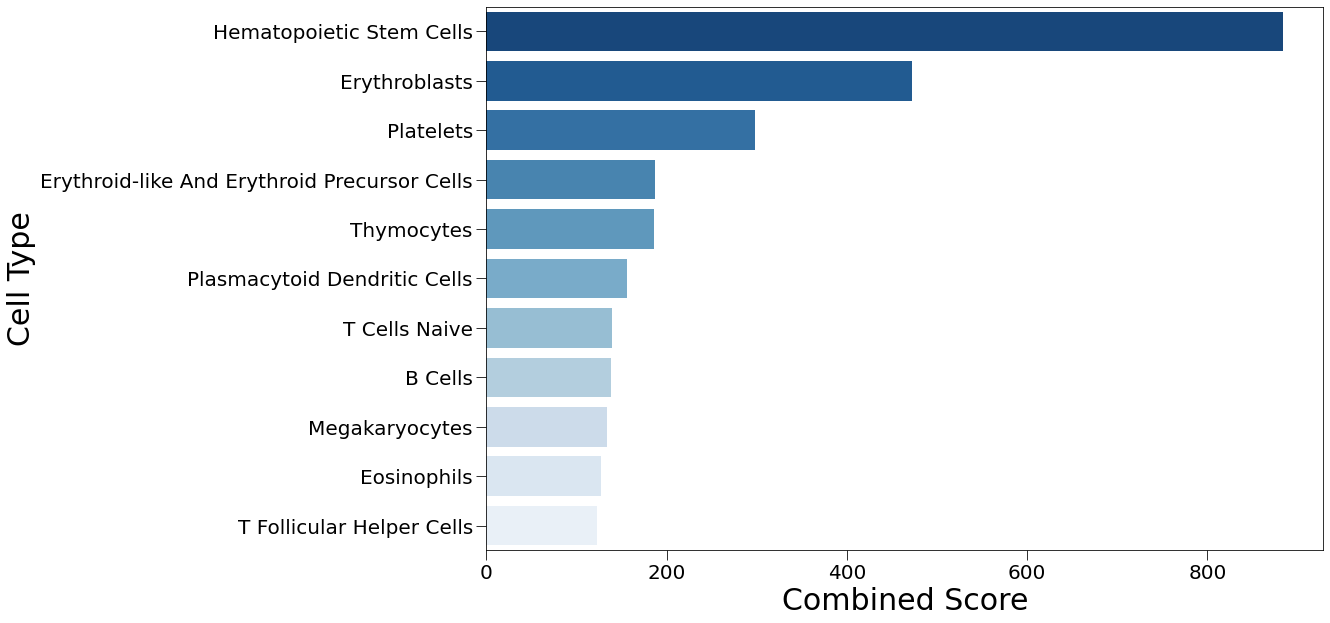

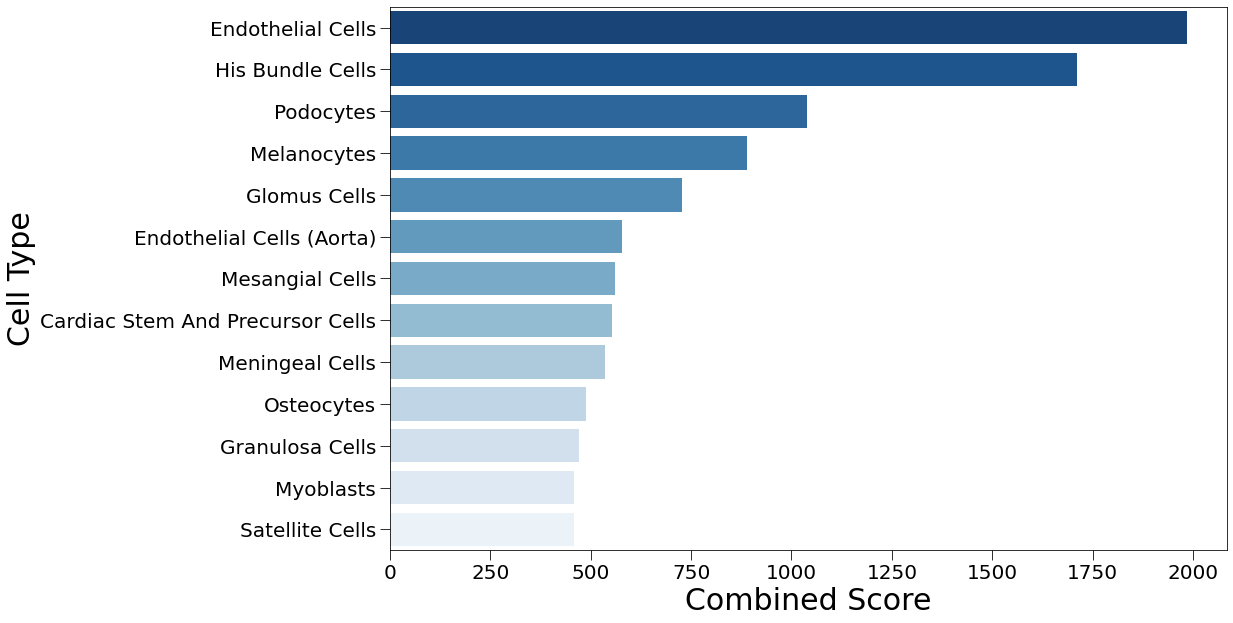

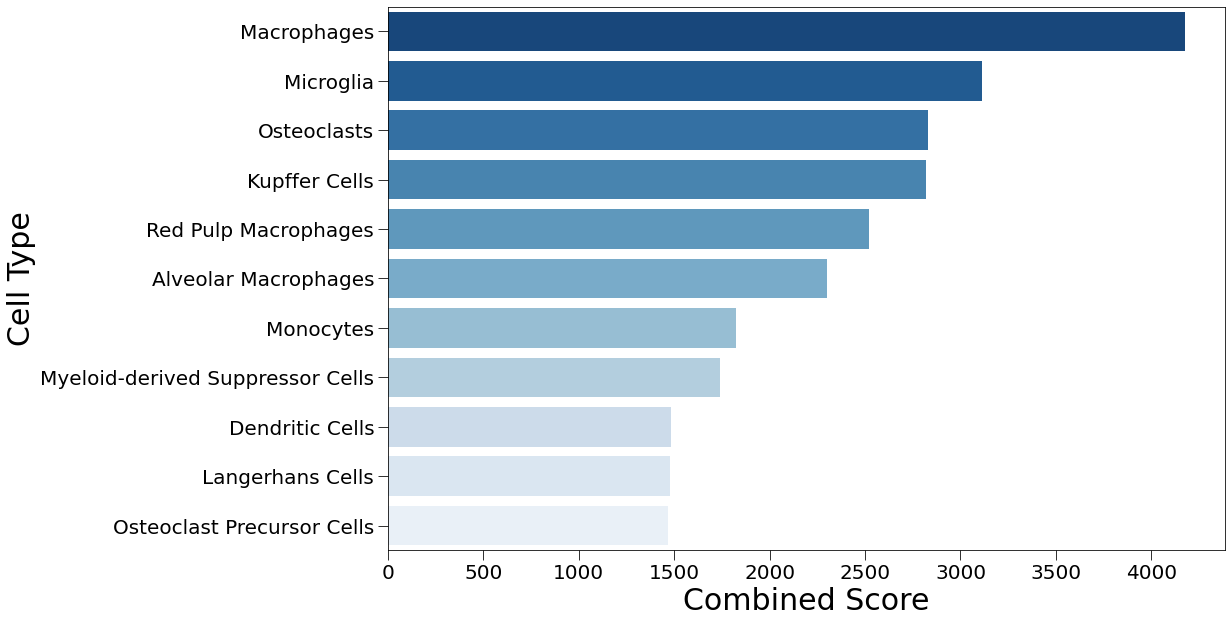

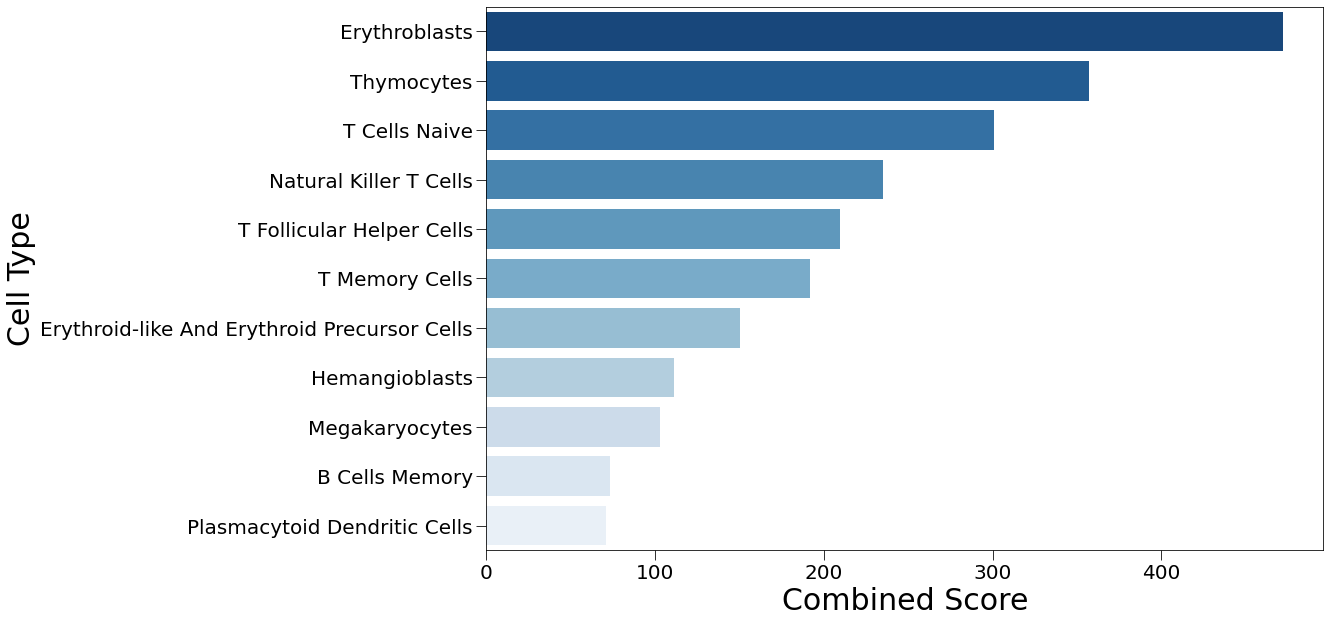

In [19]:
for library in ENRICHR_LIBRARIES:
    for sheet in pd.ExcelFile("Tables/Vink2_Enrich_"+library+".xlsx").sheet_names:
        data = pd.read_excel("Tables/Vink2_Enrich_"+library+".xlsx",sheet_name=sheet)
        data.sort_values("Combined Score",ascending=False,inplace=True)
        
        fig,ax=plt.subplots(figsize=[15,10])
        sns.barplot(data = data.loc[:10,:],x="Combined Score",y="Name",palette="Blues_r",ax=ax)
        sctplot.plot_base(ax,labels=["Combined Score","Cell Type"],legend=False)
        
        fig.savefig("Plots/Vink2_"+library+"_"+sheet+".pdf",transparent=True,bbox_inches="tight")